In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-04-08 13:24:26--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  5.69MB/s    in 14s     

2022-04-08 13:24:40 (5.01 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [ ]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [ ]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [ ]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

In [ ]:
batch_size = 64
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 707.31it/s]


In [ ]:
def Block(channels_in, channels_out, pooling=True):
    if pooling:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(channels_out),
        )
    else:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(channels_out),
        )

In [ ]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            # Block(1, 64, pooling=True),
            # Block(64, 128, pooling=True),
            # Block(128, 256, pooling=True),
            # Block(256, 512, pooling=False),

            # Block(512, 512, pooling=False),# 1
            # Block(512, 512, pooling=False),# 2
            # Block(512, 512, pooling=False),# 3

            # nn.Upsample(scale_factor=2),
            # Block(512, 256, pooling=False),
            # nn.Upsample(scale_factor=2),
            # Block(256, 128, pooling=False),
            # nn.Upsample(scale_factor=2),
            # Block(128, 64, pooling=False),

            Block(1, 64, pooling=True),
            Block(64, 128, pooling=True),
            Block(128, 256, pooling=True),
            Block(256, 512, pooling=True),

            Block(512, 512, pooling=False),
            Block(512, 512, pooling=False),
            Block(512, 512, pooling=False),

            nn.Upsample(scale_factor=2),
            Block(512, 256, pooling=False),
            nn.Upsample(scale_factor=2),
            Block(256, 128, pooling=False),
            nn.Upsample(scale_factor=2),
            Block(128, 64, pooling=False),
            nn.Upsample(scale_factor=2)
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [ ]:
num_epochs = 600
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()  # тут можно поиграться с лоссами

In [ ]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()


def show_elements_from_batch(X, y, n_to_show=4):
    model.eval()
    indxs = np.random.choice(X.shape[0], n_to_show, replace=False)
    for indx in indxs:
        img_gray, img_true = X[indx], y[indx]
        img_pred = model(img_gray.view(1, 1, 128, 128))
        img_pred = to_numpy_image(img_pred)
        plt.figure(figsize=(10,10))
        
        plt.subplot(141)
        plt.axis('off')
        plt.set_cmap('Greys')
        plt.imshow(img_gray.cpu().reshape((128, 128)))

        plt.subplot(142)
        plt.axis('off')
        plt.imshow(img_pred.reshape((128, 128, 3)))

        plt.subplot(143)
        plt.axis('off')
        plt.imshow(to_numpy_image(img_true))
        
        plt.show()
    model.train()

In [ ]:
history = []
for epoch in range(num_epochs):
    if not epoch % 50:
      print("=======" * 3)
      print(f"EPOCH: {epoch}")
    for X, y in loader:
        X_gpu, y_gpu = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        y_pred = model.forward(X_gpu)
        loss = criterion(y_gpu, y_pred)
        history.append(loss.item())
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), 'model_weights.pth')
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)
    # if epoch % 10 == 0:
      # show_elements_from_batch(X_gpu, y_gpu)

EPOCH: 0
EPOCH: 50
EPOCH: 100
EPOCH: 150
EPOCH: 200
EPOCH: 250
EPOCH: 300
EPOCH: 350
EPOCH: 400
EPOCH: 450
EPOCH: 500
EPOCH: 550


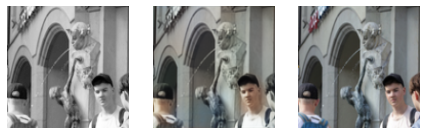

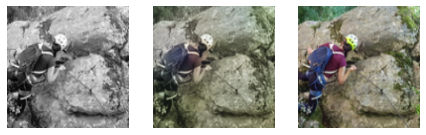

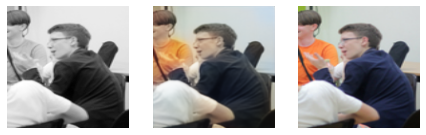

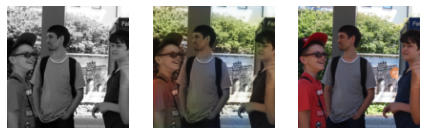

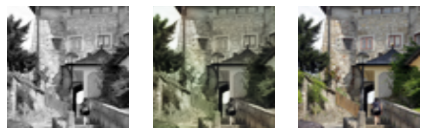

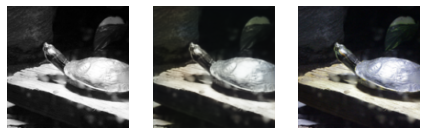

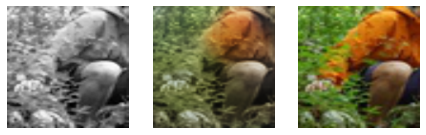

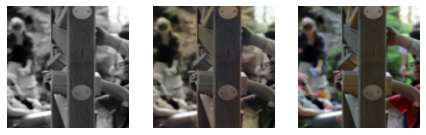

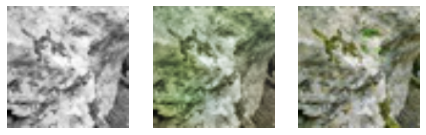

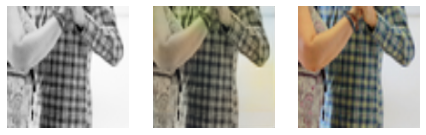

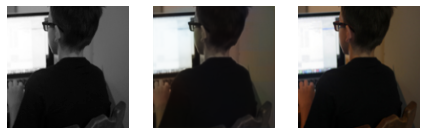

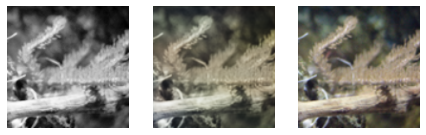

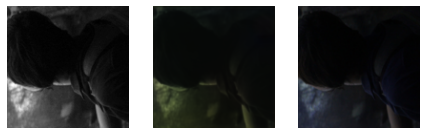

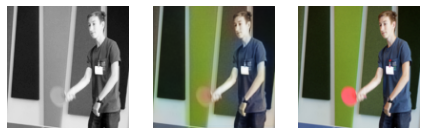

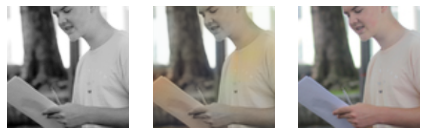

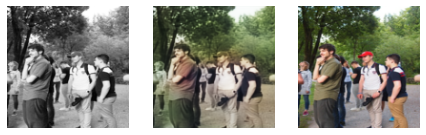

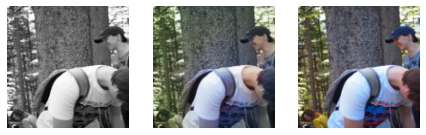

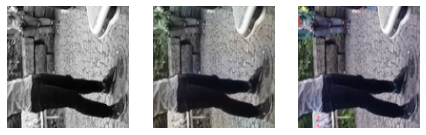

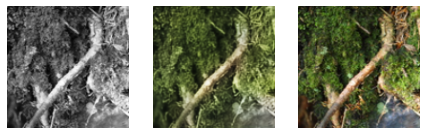

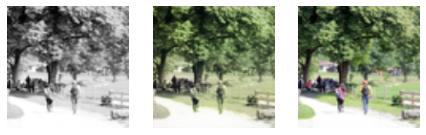

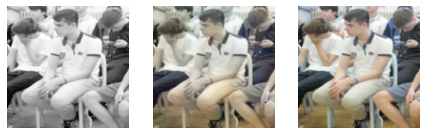

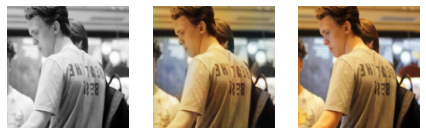

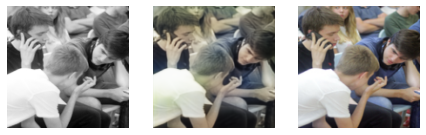

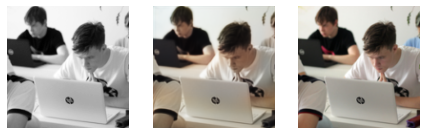

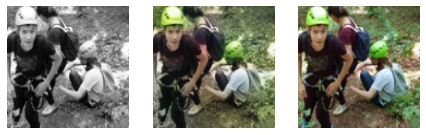

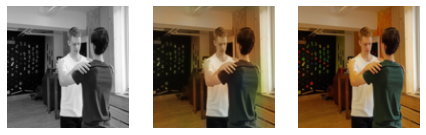

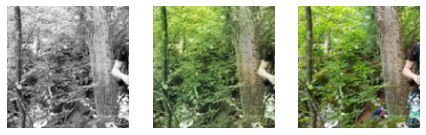

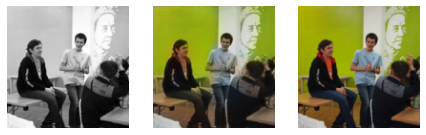

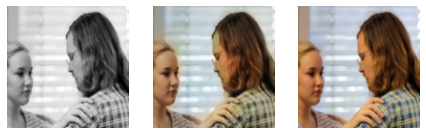

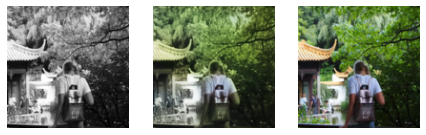

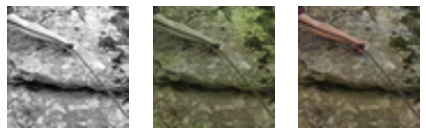

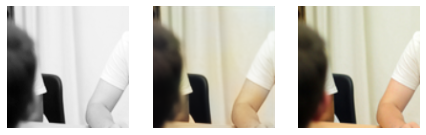

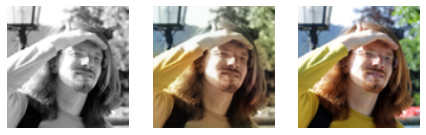

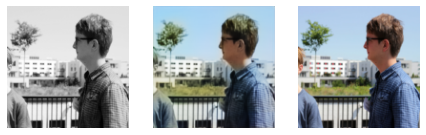

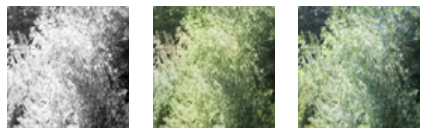

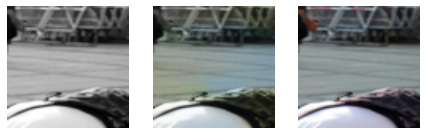

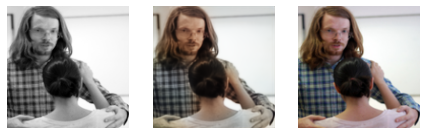

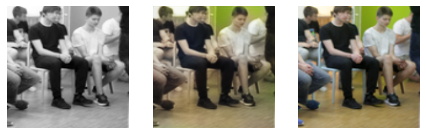

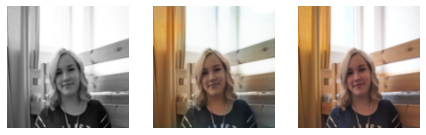

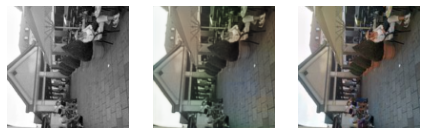

In [ ]:
# колоризация спустя 600 эпох
show_elements_from_batch(X_gpu, y_gpu, 40)

Вообще, результаты спустя 600 эпох очень даже неплохие - некоторые картинки разукрашены прям годно.

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
history = []
for epoch in range(num_epochs):
    if not epoch % 50:
      print("=======" * 3)
      print(f"EPOCH: {epoch}")
    for X, y in loader:
        X_gpu, y_gpu = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        y_pred = model.forward(X_gpu)
        loss = criterion(y_gpu, y_pred)
        history.append(loss.item())
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), 'model_weights.pth')

EPOCH: 0
EPOCH: 50
EPOCH: 100
EPOCH: 150
EPOCH: 200
EPOCH: 250
EPOCH: 300
EPOCH: 350
EPOCH: 400
EPOCH: 450
EPOCH: 500
EPOCH: 550


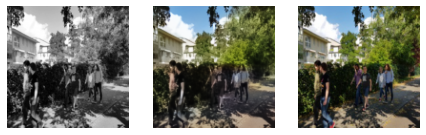

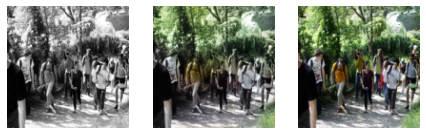

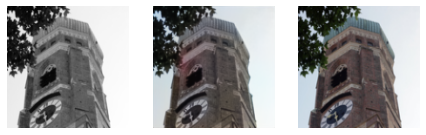

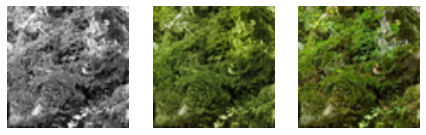

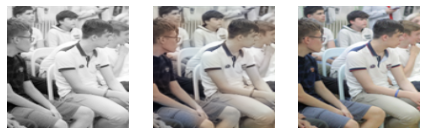

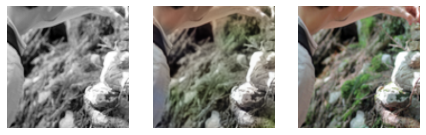

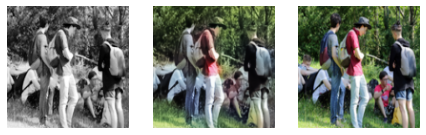

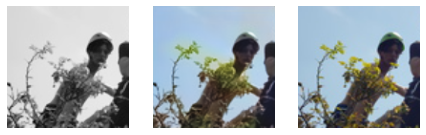

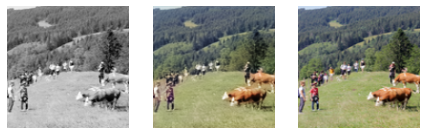

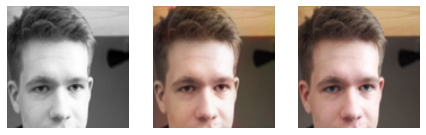

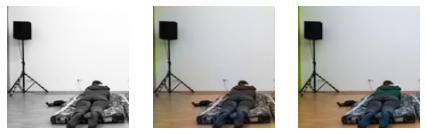

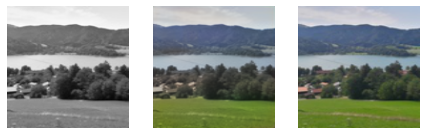

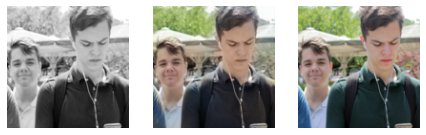

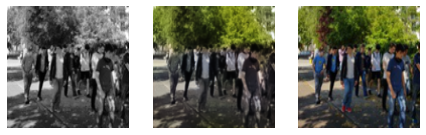

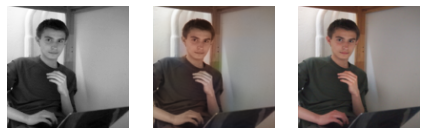

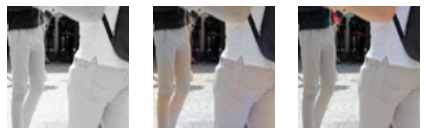

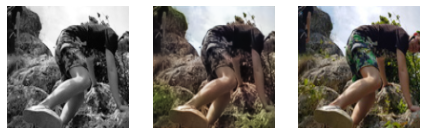

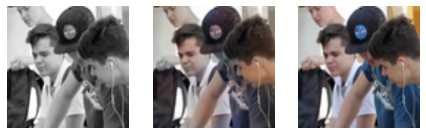

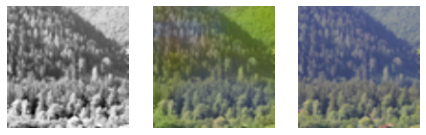

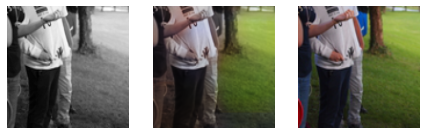

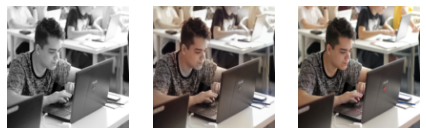

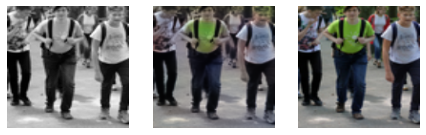

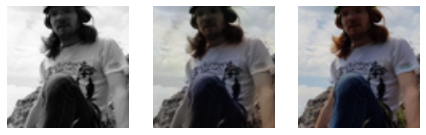

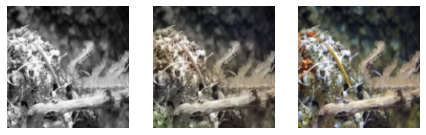

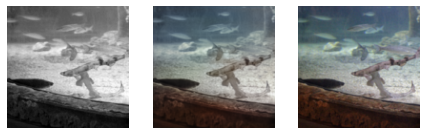

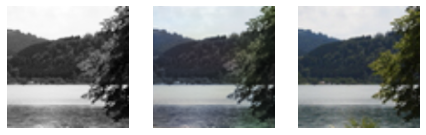

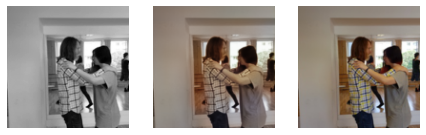

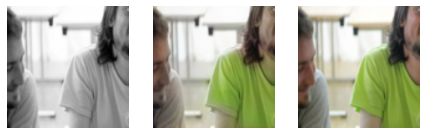

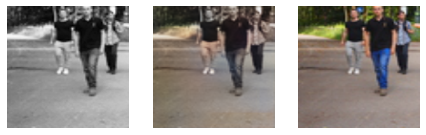

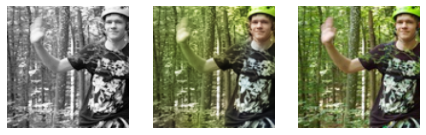

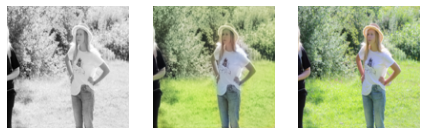

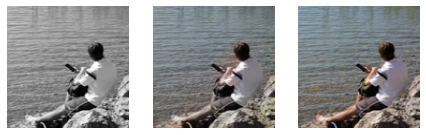

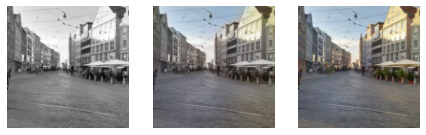

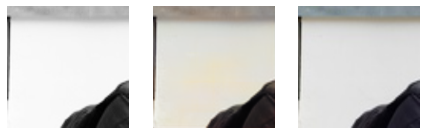

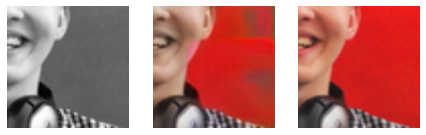

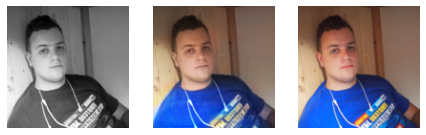

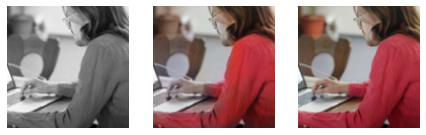

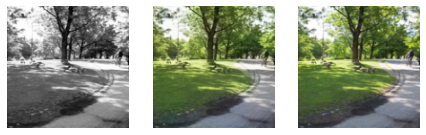

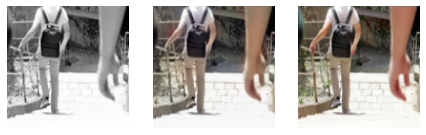

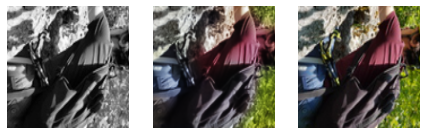

In [ ]:
# колоризация спустя 1200 эпох
show_elements_from_batch(X_gpu, y_gpu, 40)

Спустя еще 600 эпох результаты стали еще лучше - большая часть картинок разукрашены прям идеально, но есть пара исключений, например на одной из картинок моделька разукрасила кожу человека в зеленый цвет.

Результатами я остался доволен - глубокая моделька с MSE лоссом, обучаемая на 1200 эпохах, получалась вполне годная. Думаю, можно было бы еще улучшить результаты - например, поиграть с lr/глубиной/добавить дропауты. Но так как для валидации и сравнения результатов необходимо обучать модельку довольно долго - я оставил текущие.